In [240]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
drive_prefix = '/content/drive/My Drive/'

Mounted at /content/drive


In [241]:
!pip install pymorphy2
!pip install innvestigate

In [242]:
%tensorflow_version 1.x

from google.colab import files

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
russian_stopwords = stopwords.words('russian')
from nltk.tokenize import RegexpTokenizer

from pymorphy2 import MorphAnalyzer

import xml.etree.ElementTree as ET
from tqdm import tqdm

import numpy as np

from collections import Counter, defaultdict

from nltk import ngrams
import keras.backend
import keras.models

import time

import os
from gensim.models import KeyedVectors

import matplotlib.pyplot as plt
from matplotlib import cm, transforms
import innvestigate
from sklearn.model_selection import train_test_split
from collections import Counter
from itertools import chain
from innvestigate.utils.tests.networks import base as network_base

import json

import re

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:
# POSITIVE = []
# NEGATIVE = []

# 0. Processing our data

In [0]:
uploaded = files.upload()  # SentiRuEval_rest_train.zip should be uploaded

Saving SentiRuEval_rest_train.zip to SentiRuEval_rest_train.zip


In [0]:
!unzip SentiRuEval_rest_train.zip

Archive:  SentiRuEval_rest_train.zip
  inflating: SentiRuEval_rest_train.xml  


In [0]:
def pymorphy_to_udpipe(pos):
    dct = {
        'NOUN': 'NOUN',
        'ADJF': 'ADJ',
        'ADJS': 'ADJ',
        'COMP': 'ADV',
        'VERB': 'VERB',
        'INFN': 'VERB',
        'PRTF': 'ADJ',
        'PRTS': 'ADJ',
        'GRND': 'VERB',
        'NUMR': 'NUM',
        'ADVB': 'ADV',
        'NPRO': 'PRON',
        'PRED': 'ADV',
        'PREP': 'ADP',
        'CONJ': 'CCONJ',
        'PRCL': 'PART',
        'INTJ': 'INTJ'
    }
    if pos is None:
        return ''
    assert pos in dct
    return dct[pos]

In [0]:
m = MorphAnalyzer()
tokenizer = RegexpTokenizer(r'\w+')

def normalize(text):
    tokens = tokenizer.tokenize(text.lower())
    lemmas = []
    pos = []
    for token in tokens:
        m.parse(token)[0]
        tag = m.parse(token)[0]
        lemmas.append(tag.normal_form)
        pos.append(pymorphy_to_udpipe(tag.tag.POS))

    return lemmas, pos  # возвращает два массива (массив лем и массив частей речи, массивы сопряжены)

In [0]:
# %cd /content/
# tree = ET.parse('SentiRuEval_rest_train.xml')
# root = tree.getroot()

# texts = []
# food_scores = []
# interior_scores = []
# service_scores = []
# scores = []
# source_texts = []
# pos = []

# reviews = root.findall('review')
# for review in tqdm(reviews, desc='Review', total=len(reviews)):
#     text_ = review.find('text').text
#     source_texts.append(text_)
#     text_, pos_ = normalize(text_)
#     pos.append(pos_)
#     texts.append(text_)
#     review_scores = review.find('scores')
#     food_scores.append(int(review_scores.find('food').text))
#     interior_scores.append(int(review_scores.find('interior').text))
#     service_scores.append(int(review_scores.find('service').text))
#     scores.append(np.mean([food_scores[-1], interior_scores[-1], service_scores[-1]]))

/content


Review: 100%|██████████| 19034/19034 [22:01<00:00, 14.40it/s]


In [0]:
# with open(os.path.join(drive_prefix, 'parsed_texts.json'), 'w', encoding='utf-8') as f:
#     json.dump({
#         'texts': texts,
#         'food_scores': food_scores,
#         'interior_scores': interior_scores,
#         'service_scores': service_scores,
#         'scores': scores,
#         'pos': pos,
#         'source_texts': source_texts
#     }, f)

In [0]:
with open(os.path.join(drive_prefix, 'parsed_texts.json'), 'r', encoding='utf-8') as f:
    dct = json.load(f)
    texts = dct['texts']
    food_scores = dct['food_scores']
    interior_scores = dct['interior_scores']
    service_scores = dct['service_scores']
    scores = dct['scores']
    pos = dct['pos']
    source_texts = dct['source_texts']

In [0]:
# now we have lists of normalized texts, all types of scores and the mean score
' '.join(texts[0]), food_scores[0], service_scores[0], interior_scores[0], scores[0], ' '.join(pos[0])

('и пускай на я не обижаться наш прославить защитник франкофон монреаль канадиенс maxime я всегда с некоторый опаска относиться к это народ народ способный с такой благоговение доводить до цирроз весь пернатый живность заставлять специальный поисковый свиной копошиться в грязь в поиск сумчатый грибов ковыряться в тина собирать брюхоногий и двустворчатый народ подсадить весь население земной шар на муть именовать божоля нувый на сырой с плесень и на квакать жаба скакать по болото тем не менее единожды заглянуть не мочь успокоиться пока не вкусить большой часть меню не быть вдаваться в деталь вкусно невкусно а привести турнирный таблица коли начать с хоккей 1 петух запечь в сливка с картофель и гриб почему петух а не курица различать ещё не научиться 2 домашний пирог яблочный горячий таять 3 говядина по бургунски кускус неожиданный 4 террина из печень цыплёнок массивный порция 5 утиный ножка конфи с картофельный пюре мягко 6 пенний с артишок много чеснок я любить но если дышать потом на 

In [0]:
russian_stopwords = [elem for elem in russian_stopwords if elem not in ['не', 'да', 'но', 'хорошо', 'лучше', 'почти', 'никогда', 'можно', 'наконец', 'больше', 'другой', 'всего', 'много', 'впрочем', 'нельзя', 'более', 'всегда']]
texts_without_stopwords = [[word for word in text if word not in russian_stopwords] for text in texts]

In [0]:
len(texts[0]), len(texts_without_stopwords[0])

(322, 248)

Now we work with all types of n-grams.

In [0]:
bigrams = []
for text_without_stopwords in tqdm(texts, desc='Processing bigrams', total=len(texts_without_stopwords)):
    bigrams.extend(list(nltk.bigrams(text_without_stopwords)))

trigrams = []
for text_without_stopwords in tqdm(texts, desc='Processing trigrams', total=len(texts_without_stopwords)):
    trigrams.extend(nltk.trigrams(text_without_stopwords))

Processing trigrams: 100%|██████████| 19034/19034 [00:01<00:00, 14076.95it/s]


In [0]:
# bigrams[0], trigrams[0]

(('и', 'пускай'), ('и', 'пускай', 'на'))

In [0]:
# # предполагаем, что стоп-слово не может входить в коллокацию (из тех, что мы не удалили из списка nltk)
# # поэтому разобьём каждое предложение по стоп-словам и для каждого подучастка возьмём все возможные n-граммы
# # дальше посчитаем частнотность и посмотрим, стоит ли нам выделять коллокации на этом основании

# text_ngrams = []

# texts_with_partitions = [' '.join(['|' if word in russian_stopwords else word for word in text]) for text in texts]
# for text_with_partitions in texts_with_partitions:
#     for sent in text_with_partitions.split('|'):
#         sent = sent.split()
#         if sent:
#             for n in range(1, len(sent) + 1):
#                 text_ngrams.extend(ngrams(sent, n))

In [0]:
# size_to_ngrams = {}
# max_ngrams_length = len(max(text_ngrams, key=len))
# for n in tqdm(range(1, max_ngrams_length + 1), total=max_ngrams_length):
#     size_to_ngrams[n] = Counter([ngram for ngram in text_ngrams if len(ngram) == n])

In [0]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
bigram_finder = nltk.collocations.BigramCollocationFinder.from_documents(texts_without_stopwords)
bigram_finder.apply_freq_filter(3)
bi_likelihood_scores = bigram_finder.score_ngrams(bigram_measures.likelihood_ratio)
bigram_finder.nbest(bigram_measures.likelihood_ratio, 15)

[('день', 'рождение'),
 ('очень', 'понравиться'),
 ('молодая', 'человек'),
 ('p', 's'),
 ('весь', 'таки'),
 ('шеф', 'повар'),
 ('не', 'знать'),
 ('никто', 'не'),
 ('живой', 'музыка'),
 ('очень', 'вкусно'),
 ('барна', 'стойка'),
 ('очень', 'вкусный'),
 ('не', 'мочь'),
 ('весь', 'равно'),
 ('винный', 'карта')]

In [0]:
trigram_measures = nltk.collocations.TrigramAssocMeasures()
trigram_finder = nltk.collocations.TrigramCollocationFinder.from_documents(texts_without_stopwords)
trigram_finder.apply_freq_filter(3)
tri_likelihood_scores = trigram_finder.score_ngrams(trigram_measures.likelihood_ratio)
trigram_finder.nbest(trigram_measures.likelihood_ratio, 15)

[('отмечать', 'день', 'рождение'),
 ('никто', 'не', 'знать'),
 ('следующий', 'день', 'рождение'),
 ('праздновать', 'день', 'рождение'),
 ('свой', 'день', 'рождение'),
 ('отметить', 'день', 'рождение'),
 ('празднование', 'день', 'рождение'),
 ('день', 'рождение', 'подруга'),
 ('не', 'день', 'рождение'),
 ('день', 'рождение', 'муж'),
 ('отпраздновать', 'день', 'рождение'),
 ('честь', 'день', 'рождение'),
 ('день', 'рождение', 'друг'),
 ('справлять', 'день', 'рождение'),
 ('день', 'рождение', 'дочь')]

In [0]:
# def remap_keys(mapping):
#     return [{'key':k, 'value': v} for k, v in mapping.items()]

# for key, value in size_to_ngrams.items():
#     size_to_ngrams[int(key)] = remap_keys(value)

# with open(os.path.join(drive_prefix, 'size_to_ngrams.json'), 'w', encoding='utf-8') as f:
#     json.dump(size_to_ngrams, f)

In [0]:
with open(os.path.join(drive_prefix, 'size_to_ngrams.json'), 'r', encoding='utf-8') as f:
    size_to_ngrams = json.load(f)

In [0]:
def demap_keys(mapping):
    dct = {}
    for elem in mapping:
        try:
            dct[tuple(elem['key'])] = elem['value']
        except Exception:
            print(elem)
            break
    return dct

dct = {}
for key, value in size_to_ngrams.items():
    dct[int(key)] = demap_keys(value)
size_to_ngrams = dct

In [0]:
for key, value in size_to_ngrams.items():
    size_to_ngrams[key] = Counter(value)

In [0]:
# size_to_ngrams[2].most_common(10)

In [0]:
# size_to_ngrams[3].most_common(10)

In [0]:
# size_to_ngrams[4].most_common(10)

In [0]:
# size_to_ngrams[5].most_common(10)

In [0]:
# # уже слишком редко встречается, поэтому не имеет смысла добавлять 6-граммы
# size_to_ngrams[6].most_common(10)

Заменим топовые 2-граммы, ..., 5-граммы на монограммы x_y_..._z.

In [0]:
grams = {}
for size, num in zip(range(5, 1, -1), [5, 15, 50, 100]):
    grams[size] = [' '.join(elem[0]) for elem in size_to_ngrams[size].most_common(num)]

bigrams = [' '.join(elem) for elem in bigram_finder.nbest(bigram_measures.likelihood_ratio, 50)]
trigrams = [' '.join(elem) for elem in trigram_finder.nbest(trigram_measures.likelihood_ratio, 25)]

grams_to_be_replaced = []

texts_with_replacements = []
for text in tqdm(texts_without_stopwords, desc='Text', total=len(texts_without_stopwords)):
    text = ' '.join(text)

    for i in range(5, 3, -1):
        for gram in grams[i]:
            grams_to_be_replaced.append(gram)
            text = text.replace(gram, gram.replace(' ', '_'))

    for ngrams_ in [trigrams, bigrams]:
        for gram in ngrams_:
            grams_to_be_replaced.append(gram)
            text = text.replace(gram, gram.replace(' ', '_'))

    for i in range(3, 1, -1):
        for gram in grams[i]:
            grams_to_be_replaced.append(gram)
            text = text.replace(gram, gram.replace(' ', '_'))

    texts_with_replacements.append(text)

Text: 100%|██████████| 19034/19034 [00:06<00:00, 3000.74it/s]


In [0]:
# with open(os.path.join(drive_prefix, 'parsed_texts_with_replacements.json'), 'w', encoding='utf-8') as f:
#     json.dump(texts_with_replacements, f)

In [0]:
with open(os.path.join(drive_prefix, 'parsed_texts_with_replacements.json'), 'r', encoding='utf-8') as f:
    texts_with_replacements = json.load(f)

In [0]:
# # Чтобы в colab-е tqdm хорошо работала
# for instance in list(tqdm._instances):
#     tqdm._decr_instances(instance)

In [0]:
# texts_with_replacements[:5]

In [0]:
# Now we turn scores from 1-10 to 0-1
scores = np.array(scores)
binary_scores = scores > 5.
print(binary_scores[0])

True


In [0]:
binary_scores = binary_scores.astype(int)

In [0]:
# print(len(texts))
# print(len(scores))

#1. TF-IDF

In [0]:
# from sklearn.feature_extraction.text import TfidfVectorizer

In [0]:
# vectorizer = TfidfVectorizer(min_df=0.1)
# tfidf_matrix = vectorizer.fit_transform(texts_with_replacements)

# pos_indices = []
# neg_indices = []
# for i, binary_score in zip(range(tfidf_matrix.shape[0]), binary_scores):
#     arr = tfidf_matrix[i].toarray().squeeze()
#     indices = list(arr.argsort()[-5:])
#     if binary_score:
#         pos_indices.extend(indices)
#     else:
#         neg_indices.extend(indices)



# vocab = vectorizer.get_feature_names()
# pos_words = [vocab[pos_index] for pos_index in pos_indices]
# neg_words = [vocab[neg_index] for neg_index in neg_indices]


# pos_counter = Counter(pos_words)
# pos_counter = {elem: pos_counter[elem] for elem in pos_counter if pos_counter[elem] >= 35}
# neg_counter = Counter(neg_words)
# neg_counter = {elem: neg_counter[elem] for elem in neg_counter if neg_counter[elem] >= 15}


# common_words = set(pos_counter.keys()) & set(neg_counter.keys())
# mostly_positive_words = []
# mostly_negative_words = []
# for elem in list(common_words):
#     if (pos_counter[elem] / 75970) / (neg_counter[elem] / 19200) > 1.4:
#         mostly_positive_words.append(elem)
#     elif (pos_counter[elem] / 75970) / (neg_counter[elem] / 19200) < 0.6:
#         mostly_negative_words.append(elem)

Логика (from Эдик): для каждого текста берется 5 слов с наибольшим значением tf-idf. Они добавляются в списки положительных (pos_words) и отрицательных (neg_words) слов. Если какое-то слово часто встречается в положительных предложения, значит, оно мега положительное (mostly_positive_word), с отрицательными (mostly_negative_words) аналогично.

In [0]:
# print(len(mostly_negative_words), len(mostly_positive_words))

14 27


In [0]:
# POSITIVE.extend(mostly_positive_words)
# NEGATIVE.extend(mostly_negative_words)

In [0]:
# print(POSITIVE)

['кухня', 'понравиться', 'спасибо', 'но', 'хотеться', 'персонал', 'выбор', 'уютный', 'вино', 'вкусный', 'соус', 'место', 'вкус', 'отличный', 'вкусно', 'хороший', 'атмосфера', 'всегда', 'очень', 'десерт', 'много', 'приятный', 'музыка', 'интерьер', 'весь', 'хорошо', 'быстро']


In [0]:
# print(NEGATIVE)

['человек', 'официантка', 'счёт', 'заказать', 'туда', 'вообще', 'заказ', 'принести', 'администратор', 'минута', 'сказать', 'ждать', 'решить', 'официант']


#FINDING ASPECT

## RuTez

Ищем аспект для слов их POSITIVE и NEGATIVE, чтобы записать их в OUTPUT.

In [0]:
# !wget https://github.com/sjut/HSE-Compling/raw/master/seminars/data/relations_with_concepts.csv

--2019-12-23 22:30:53--  https://github.com/sjut/HSE-Compling/raw/master/seminars/data/relations_with_concepts.csv
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/sjut/HSE-Compling/master/seminars/data/relations_with_concepts.csv [following]
--2019-12-23 22:30:54--  https://raw.githubusercontent.com/sjut/HSE-Compling/master/seminars/data/relations_with_concepts.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10359319 (9.9M) [text/plain]
Saving to: ‘relations_with_concepts.csv’

relations_with_conc 100%[===================>]   9.88M  65.4MB/s    in 0.2s    

2019-12-23 22:30:55 (65.4 MB/s) - ‘rela

In [0]:
# import csv

# rels_list = []
# with open("relations_with_concepts.csv", newline='', encoding='utf8') as rels:
#     reader = csv.DictReader(rels, delimiter="\t")
#     for row in reader:
#         rels_list.append(row)

# def get_supc(concept_list, rels_list, has_up=True, depth=0, max_depth=-1):
#     """
#     Find list of all hypernyms of query by level down
#     [[level_1], [level_2.1, level_2.2], [level_3.1, level_3.2, level_3.3], etc...]

#     :param concept_list: search input
#     :param rels_list: imported set of relations
#     :param max_depth: maximum allowed number of hyponyms
#     :param has_up: (internal) bool(current top concept has a subconcept)
#     :param depth: (internal) current depth in the ontology
#     :return: list of subconcepts for every meaning of query
#     """
#     if (not has_up) or depth >= max_depth > 0:
#         return concept_list
#     has_up = False
#     new_list = []
#     for word in concept_list[-1]:
#         for row in rels_list:
#             if row['from'].lower() == word.lower() and row['relation'] == 'ВЫШЕ':
#                 if all(row['to'].lower() not in hypo for hypo in concept_list):
#                     new_list.append(row['to'].lower())
#                     has_up = True
#     if has_up:
#         concept_list.append(new_list)
#     return get_supc(concept_list, rels_list, has_up, depth + 1, max_depth)

In [0]:
# from collections import namedtuple # for output
# word2output = namedtuple('word2output', ['aspect', 'word', 'score'])

# final_words = []
# food = ['еда', 'пища', 'блюдо', 'продукты питания']
# service = ['обслуживание', 'сервис', 'персонал', 'услуга', 'должность',
#            'обслуживающий персонал']

In [0]:
# because of runtime i made this. should be deleted
# NEGATIVE = ['человек', 'официант', 'ждать', 'официантка', 'туда', 'заказ', 'заказать', 'решить', 'принести', 'сказать', 'вообще', 'минута', 'администратор', 'счёт']
# POSITIVE = ['всегда', 'интерьер', 'вкусно', 'много', 'отличный', 'спасибо', 'приятный', 'быстро', 'атмосфера', 'самый', 'место', 'десерт', 'весь', 'кухня', 'вкусный', 'музыка', 'хороший', 'очень', 'хотеться', 'понравиться', 'уютный', 'вкус', 'выбор', 'персонал', 'соус', 'хорошо']

In [0]:
# for word in POSITIVE:
#   hyperonims = get_supc([[word]], rels_list)
#   for hyperonim in hyperonims:
#     hyperonim = ' '.join(hyperonim) if isinstance(hyperonim,list) else hyperonim
#     for item in food:
#       if item in hyperonim:
#         final_words.append(word2output('Food', word, 1))
#     for item in service:
#       if item in hyperonim:
#         final_words.append(word2output('Service', word, 1))

# for word in NEGATIVE:
#   hyperonims = get_supc([[word]], rels_list)
#   for hyperonim in hyperonims:
#     hyperonim = ' '.join(hyperonim) if isinstance(hyperonim,list) else hyperonim
#     for item in food:
#       if item in hyperonim:
#         final_words.append(word2output('Food', word, 0))
#     for item in service:
#       if item in hyperonim:
#         final_words.append(word2output('Service', word, 0))
    

# final_words = list(set(final_words))
# print(final_words)
# print(len(final_words))

[word2output(aspect='Service', word='официант', score=0), word2output(aspect='Service', word='администратор', score=0), word2output(aspect='Service', word='персонал', score=1), word2output(aspect='Food', word='соус', score=1), word2output(aspect='Food', word='вино', score=1), word2output(aspect='Food', word='десерт', score=1)]
6


Добавляется мало слов, потому что не находятся гиперонимы (см. ячейку ниже)

In [0]:
# for word in NEGATIVE:
#   print('WORD:', word)
#   print(get_supc([[word]], rels_list))

WORD: человек
[['человек'], ['живой организм', 'субъект деятельности'], ['биологическая сущность', 'постоянная сущность'], ['физическая сущность']]
WORD: официантка
[['официантка']]
WORD: счёт
[['счёт']]
WORD: заказать
[['заказать']]
WORD: туда
[['туда']]
WORD: вообще
[['вообще']]
WORD: заказ
[['заказ']]
WORD: принести
[['принести']]
WORD: администратор
[['администратор'], ['должностное лицо', 'административная должность'], ['служащий (работник)', 'должность'], ['работник', 'роль, положение, место'], ['человек'], ['живой организм', 'субъект деятельности'], ['биологическая сущность', 'постоянная сущность'], ['физическая сущность']]
WORD: минута
[['минута']]
WORD: сказать
[['сказать']]
WORD: ждать
[['ждать']]
WORD: решить
[['решить']]
WORD: официант
[['официант'], ['обслуживающий персонал', 'работник общественного питания'], ['работник', 'работник'], ['человек', 'человек'], ['живой организм', 'субъект деятельности', 'живой организм', 'субъект деятельности'], ['биологическая сущность', 'п

## Wiki_ru_wordnet

In [0]:
# import nltk
# !pip install wiki_ru_wordnet

In [0]:
# from wiki_ru_wordnet import WikiWordnet
# import re
# wikiwordnet = WikiWordnet()

In [0]:
# for word in POSITIVE:
#   print('word', word)
#   synsets = wikiwordnet.get_synsets(word)
#   if len(synsets) == 0:
#     continue
#   else:
#     for synset in synsets:
#       for hypernym in wikiwordnet.get_hypernyms(synset):
#         hyperonims = [w.lemma() for w in hypernym.get_words()]
#         print('hyperonims for word {}: {}'.format(word, hyperonims))
#         for aspect in food:
#           if aspect in hyperonims:
#             print('WE FOUND EDA')
#         for aspect in service:
#           if aspect in hyperonims:
#             print('WE FOUND SERVICE')

word всегда
hyperonims for word всегда: ['местоименное наречие']
word интерьер
word вкусно
hyperonims for word вкусно: ['приятно']
word много
hyperonims for word много: ['избыток']
hyperonims for word много: ['множество']
hyperonims for word много: ['единица', 'мера']
word отличный
hyperonims for word отличный: ['иной']
hyperonims for word отличный: ['остальной', 'прочий', 'другой', 'иной']
hyperonims for word отличный: ['необычный', 'необыкновенный', 'непривычный', 'странный', 'причудливый', 'чудной']
hyperonims for word отличный: ['шикарный', 'роскошный', 'богатый']
hyperonims for word отличный: ['хороший']
hyperonims for word отличный: ['пригожий', 'привлекательный', 'смазливый', 'симпатичный', 'приятный', 'хорошенький', 'красивый', 'миловидный']
word спасибо
hyperonims for word спасибо: ['признательность']
word приятный
hyperonims for word приятный: ['кузявый']
hyperonims for word приятный: ['кузявый']
word быстро
hyperonims for word быстро: ['быстренько']
word атмосфера
hyperonims

## Yet another try to find aspect - ADAGRAM

Идея такая: Подрубить Адаграм. Посмотреть для POSITIVE и NEGATIVE на соседей, с которыми они встречаются. Если есть что-то из списка FOOD or SERIVICE - добавляем в final_words

In [0]:
# !pip install git+https://github.com/lopuhin/python-adagram.git

  Cloning https://github.com/lopuhin/python-adagram.git to /tmp/pip-req-build-d0sta04w
  Running command git clone -q https://github.com/lopuhin/python-adagram.git /tmp/pip-req-build-d0sta04w
  Created wheel for adagram: filename=adagram-0.0.1-cp36-cp36m-linux_x86_64.whl size=464594 sha256=d03658ed64481cf2fac327fa9e2f9aa13486ecb0aac66444b4a4dc7e22e26913
  Stored in directory: /tmp/pip-ephem-wheel-cache-b3rug6kb/wheels/11/0f/46/f5df96670df8f7973b4c2311ffc9b02e435a7bd3207f992c4d
Successfully built adagram


In [0]:
# import adagram

In [0]:
# !wget https://s3.amazonaws.com/kostia.lopuhin/all.a010.p10.d300.w5.m100.nonorm.slim.joblib

--2019-12-22 01:55:40--  https://s3.amazonaws.com/kostia.lopuhin/all.a010.p10.d300.w5.m100.nonorm.slim.joblib
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.142.198
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.142.198|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1462416741 (1.4G) [application/x-www-form-urlencoded]
Saving to: ‘all.a010.p10.d300.w5.m100.nonorm.slim.joblib’

all.a010.p10.d300.w 100%[===================>]   1.36G  70.0MB/s    in 20s     

2019-12-22 01:56:00 (70.2 MB/s) - ‘all.a010.p10.d300.w5.m100.nonorm.slim.joblib’ saved [1462416741/1462416741]



In [0]:
# vm = adagram.VectorModel.load('all.a010.p10.d300.w5.m100.nonorm.slim.joblib')

In [0]:
# for word in POSITIVE:
#   try:
#     definitions = vm.word_sense_probs(word)
#   except:
#     continue
#   for i, _ in enumerate(definitions):
#     neighbors = vm.sense_neighbors(word, i)
#     for neighbor in neighbors:
#       if neighbor[0] in food:
#         #print(neighbor[0], word, food)
#         final_words.append(word2output('Food', word, 1))
#       if neighbor[0] in service:
#         #print(neighbor[0], word, service)
#         final_words.append(word2output('Service', word, 1))

# for word in NEGATIVE:
#   try:
#     definitions = vm.word_sense_probs(word)
#   except:
#     continue
#   for i, _ in enumerate(definitions):
#     neighbors = vm.sense_neighbors(word, i)
#     for neighbor in neighbors:
#       if neighbor[0] in food:
#         #print(neighbor[0], word, food)
#         final_words.append(word2output('Food', word, 0))
#       if neighbor[0] in service:
#         #print(neighbor[0], word, service)
#         final_words.append(word2output('Service', word, 0))

# final_words = list(set(final_words))
# print(final_words)
# print(len(final_words))

/usr/local/lib/python3.6/dist-packages/adagram/model.py:124: RuntimeWarning: invalid value encountered in true_divide
  sim_matrix = np.dot(self.In, s_v) / self.InNorms


[word2output(aspect='Service', word='персонал', score=1), word2output(aspect='Food', word='вкус', score=1), word2output(aspect='Service', word='администратор', score=0), word2output(aspect='Service', word='официант', score=0), word2output(aspect='Food', word='соус', score=1), word2output(aspect='Food', word='кухня', score=1), word2output(aspect='Food', word='вкусный', score=1), word2output(aspect='Food', word='десерт', score=1)]
8


## TO OUTPUT FILE

Writing final_words to output txt file in the right format. Each element in final_word is a namedtuple with structure: word2output = namedtuple('word2output', ['aspect', 'word', 'score'])

In [0]:
# final_words = [word2output('Service', 'официант', '0'),  word2output('Service', 'официант', '0')]
# word2output = namedtuple('word2output', ['aspect', 'word', 'score'])

In [0]:
# with open('output_task1.txt', 'w', encoding='utf-8') as f:
#     for item in final_words:
#         f.write('{}\t{}\t{}\n'.format(item.aspect, item.word, item.score))

In [0]:
# # На случай если нужно расширить именно те файлы, ссылки на которые даны в гугл доке
# # Тут ссылки неправильные, исправьте плиз если нужно будет все таки в эти файлы записывать, а не один новый создать
# !wget -O food.txt https://docs.google.com/document/d/1niutB_Vz8giXd6Fiv5dQ_3JXOqg9Vs7eMXMgAdsyF-c/edit
# !wget -O service.txt https://drive.google.com/file/d/1EdOueBXcT8KyDdcGylTkskfAc-dGcSyF/view

--2019-12-21 23:39:39--  https://docs.google.com/document/d/1niutB_Vz8giXd6Fiv5dQ_3JXOqg9Vs7eMXMgAdsyF-c/edit
Resolving docs.google.com (docs.google.com)... 74.125.195.101, 74.125.195.102, 74.125.195.139, ...
Connecting to docs.google.com (docs.google.com)|74.125.195.101|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘food.txt’

food.txt                [ <=>                ] 124.60K  --.-KB/s    in 0.06s   

2019-12-21 23:39:40 (1.97 MB/s) - ‘food.txt’ saved [127591]

--2019-12-21 23:39:40--  https://drive.google.com/file/d/1EdOueBXcT8KyDdcGylTkskfAc-dGcSyF/view
Resolving drive.google.com (drive.google.com)... 74.125.197.138, 74.125.197.100, 74.125.197.139, ...
Connecting to drive.google.com (drive.google.com)|74.125.197.138|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘service.txt’

service.txt             [ <=>                ]  67.77K  --.-KB/s    in 0.03s   

In [0]:
# with open('food.txt', 'a', encoding='utf-8') as f:
#   for item in final_words:
#     if item.aspect == 'Food':
#       f.write('{}\t{}\t{}\n'.format(item.aspect, item.word, item.score))
# with open('service.txt', 'a', encoding='utf-8') as f:
#   for item in final_words:
#     if item.aspect == 'Service':
#       f.write('{}\t{}\t{}\n'.format(item.aspect, item.word, item.score))

# 2. CNN

### Seminar corpus - skip if you want to run cnn on development corpus

In [0]:
# !wget https://raw.githubusercontent.com/sjut/HSE-Compling/master/seminars/data/reviews_tok.txt
# !wget https://raw.githubusercontent.com/sjut/HSE-Compling/master/seminars/data/reviews_scores.txt

--2019-12-22 22:40:25--  https://raw.githubusercontent.com/sjut/HSE-Compling/master/seminars/data/reviews_tok.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8489426 (8.1M) [text/plain]
Saving to: ‘reviews_tok.txt’

reviews_tok.txt     100%[===================>]   8.10M  --.-KB/s    in 0.1s    

2019-12-22 22:40:25 (62.4 MB/s) - ‘reviews_tok.txt’ saved [8489426/8489426]

--2019-12-22 22:40:27--  https://raw.githubusercontent.com/sjut/HSE-Compling/master/seminars/data/reviews_scores.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 373

In [0]:
# texts = []
# with open("reviews_tok.txt") as f:
#     for line in f:
#         texts.append(line.rstrip('\r\n').split())
# scores = []
# with open("reviews_scores.txt") as f:
#     scores = list(map(lambda x: float(x.rstrip("\r\n")), f.readlines()))

In [0]:
# scores = np.array(scores)
# binary_scores = scores > 5.
# print(binary_scores[0])
# binary_scores = binary_scores.astype(int)[:2994]

True


In [0]:
# texts[0]

['понравиться_VERB',
 '._PUNCT',
 'не_PART',
 'супер_NOUN',
 '-_PUNCT',
 'пупер_NOUN',
 ',_PUNCT',
 'но_CCONJ',
 'вполне_ADV',
 'мять_VERB',
 ',_PUNCT',
 'вкусно_ADV',
 'и_PART',
 'ценник_NOUN',
 'демократичный_ADJ']

### Development corpus

In [0]:
# with open(os.path.join(drive_prefix, 'texts.txt'), 'w', encoding='utf-8') as f:
#     f.write('\n'.join(texts_with_replacements))

In [0]:
# !chmod 777 /content/drive/My\ Drive/udpipe/bin-linux64/udpipe
# !/content/drive/My\ Drive/udpipe/bin-linux64/udpipe --input horizontal --output conllu \
# --tokenize --tag --parse \
# /content/drive/My\ Drive/russian-syntagrus.udpipe \
# < /content/drive/My\ Drive/texts.txt > /content/drive/My\ Drive/texts.conllu

Loading UDPipe model: done.


In [0]:
# texts = []

# with open(os.path.join(drive_prefix, 'texts.conllu'), 'r', encoding='utf-8') as f:
#     parsed_sents = f.read().split('\n\n')
#     text_num = 0
#     texts.append([])
#     word_num = 0
#     for sent in tqdm(parsed_sents, desc="Sentences", total=len(parsed_sents)):
#         tree = [line for line in sent.split('\n') if line and line[0] != '#']
#         for word in tree:
#             _, lemma, _, pos, *_ = word.split('\t')
#             if word_num == len(texts_with_replacements[text_num].split()):
#                 texts.append([])
#                 text_num += 1
#                 word_num = 0
#             if ' ' in lemma:
#                 lemmas = lemma.split()
#             else:
#                 lemmas = [lemma]

#             for lemma in lemmas:
#                 if word_num == len(texts_with_replacements[text_num].split()):
#                     texts.append([])
#                     text_num += 1
#                     word_num = 0
#                 if lemma == texts_with_replacements[text_num].split()[word_num]:
#                     word_num += 1
#                 elif texts_with_replacements[text_num].split()[word_num].endswith(lemma):
#                     word_num += 1
#                 if '_' in lemma:
#                     texts[-1].append(f'{lemma}_X')
#                 else:
#                     texts[-1].append(f'{lemma}_{pos}')

Sentences: 100%|██████████| 4114/4114 [02:01<00:00, 33.82it/s]


In [0]:
# with open(os.path.join(drive_prefix, 'texts_with_pos.json'), 'w', encoding='utf-8') as f:
#     json.dump(texts, f)

In [0]:
with open(os.path.join(drive_prefix, 'texts_with_pos.json'), 'r', encoding='utf-8') as f:
    texts = json.load(f)

In [0]:
# # Чтобы в colab-е tqdm хорошо работала
# for instance in list(tqdm._instances):
#     tqdm._decr_instances(instance)

Все это делаем на наших текстах (texts)

In [0]:
!wget http://vectors.nlpl.eu/repository/11/180.zip
!unzip 180.zip

--2019-12-24 19:41:45--  http://vectors.nlpl.eu/repository/11/180.zip
Resolving vectors.nlpl.eu (vectors.nlpl.eu)... 129.240.189.225
Connecting to vectors.nlpl.eu (vectors.nlpl.eu)|129.240.189.225|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 484452285 (462M) [application/zip]
Saving to: ‘180.zip’

180.zip             100%[===================>] 462.01M  23.2MB/s    in 23s     

2019-12-24 19:42:09 (20.4 MB/s) - ‘180.zip’ saved [484452285/484452285]

Archive:  180.zip
  inflating: README                  
  inflating: meta.json               
  inflating: model.bin               
  inflating: model.txt               


In [0]:
w2v_model = KeyedVectors.load_word2vec_format('model.bin', binary=True)

In [0]:
embedding_dim = w2v_model.vector_size

In [0]:
scores_train, scores_val, texts_train, texts_val = train_test_split(
    binary_scores[:4000], texts[:4000], test_size=0.3, random_state=42)

In [0]:
def max_length(texts):
    return max(len(t) for t in texts)

In [0]:
MAX_LEN = max(max_length(texts_train), max_length(texts_val))

def load_dataset(lines, embedding_dim, num_examples=None):
    prep = lines[:num_examples]
    vocab = Counter()
    x_tensor = np.zeros((len(prep), MAX_LEN, embedding_dim))
    for i, text in enumerate(prep):
        w = None
        for j, w in enumerate(text):
            try:
                if '_' in w:
                    vectors = []
                    for ww in w.split('_')[:-1]:
                        ww += '_' + pymorphy_to_udpipe(m.parse(ww)[0].tag.POS)
                        try:
                            vectors.append(w2v_model[ww])
                        except KeyError:
                            pass
                    if vectors:
                        x_tensor[i, j, :] = np.mean(np.array(vectors), axis=0)
                    else:
                        x_tensor[i, j, :] = np.zeros((1, embedding_dim))

                else:
                    x_tensor[i, j, :] = w2v_model[w]
            except KeyError:
                pass
        if w is not None:
            vocab[w] += 1
    return x_tensor, vocab

In [0]:
input_tensor_train, inp_vocab_train = load_dataset(texts_train, w2v_model.vector_size)
# input_tensor_val, inp_vocab_val = load_dataset(texts_val, w2v_model.vector_size)

In [0]:
# w2v_model.vector_size, input_tensor_train.shape

(300, (2800, 911, 300))

In [0]:
# scores_train

array([0, 1, 1, ..., 1, 1, 1])

In [0]:
# inp_vocab = inp_vocab_train + inp_vocab_val
# vocab_inp_size = len(inp_vocab)+1

# print(vocab_inp_size)

1867


In [0]:
# def build_network(max_len, voc_size, embedding_dim, output_n, activation=None, dense_unit=256, dropout_rate=0.25):
#     if activation:
#         activation = "relu"

#     net = {}
#     net["in"] = keras.Input(shape=[1, max_len, embedding_dim])
#     net["conv"] = keras.layers.Conv2D(filters=100, kernel_size=(1,2), strides=(1, 1), padding='valid')(net["in"])
#     net["pool"] = keras.layers.MaxPooling2D(pool_size=(1, max_len-1), strides=(1,1))(net["conv"])
#     net["out"] = network_base.dense_layer(keras.layers.Flatten()(net["pool"]), units=output_n, activation=activation)
#     net["sm_out"] = network_base.softmax(net["out"])


#     net.update({
#         "input_shape": [1, max_len, embedding_dim],
#         "output_n": output_n,
#     })
#     return net

# net = build_network(MAX_LEN, vocab_inp_size, embedding_dim, 2)
# model_without_softmax = keras.models.Model(inputs=net['in'], outputs=net['out'])
# model_with_softmax = keras.models.Model(inputs=net['in'], outputs=net['sm_out'])

In [0]:
# model_without_softmax.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 911, 300)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 910, 100)       60100     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 1, 100)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 202       
Total params: 60,302
Trainable params: 60,302
Non-trainable params: 0
_________________________________________________________________


In [0]:
# def to_one_hot(y):
#     return keras.utils.to_categorical(y, 2)

# def train_model(model, epochs=20):
    
#     x_train = np.expand_dims(input_tensor_train, axis=1)
#     y_train = to_one_hot(scores_train)
    
#     x_val = np.expand_dims(input_tensor_val, axis=1)
#     y_val = to_one_hot(scores_val)

#     model.compile(loss='categorical_crossentropy',
#                   optimizer=keras.optimizers.Adam(),
#                   metrics=['accuracy'])

#     history = model.fit(x_train, y_train,
#                         batch_size=256,
#                         epochs=epochs,
#                         verbose=1,
#                         validation_data=(x_val, y_val),
#                         shuffle=True
#                        )

In [0]:
# train_model(model_with_softmax, epochs=50)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 2800 samples, validate on 1200 samples
Epoch 1/50





2800/2800 [==============================] - 19s 7ms/step - loss: 0.9899 - acc: 0.7050 - val_loss: 0.7270 - val_acc: 0.8000
Epoch 2/50
2800/2800 [==============================] - 4s 1ms/step - loss: 0.4993 - acc: 0.8025 - val_loss: 0.5004 - val_acc: 0.8092
Epoch 3/50
2800/2800 [==============================] - 4s 2ms/step - loss: 0.3338 - acc: 0.8657 - val_loss: 0.5267 - val_acc: 0.7667
Epoch 4/50
2800/2800 [==============================] - 4s 2ms/step - loss: 0.2509 - acc: 0.9021 - val_loss: 0.4612 - val_acc: 0.8092
Epoch 5/50
2800/2800 [==============================] - 4s 2ms/step - loss: 0.1902 - acc: 0.9354 - val_loss: 0.4606 - val_acc: 0.8100
Epoch 6/50
2800/2800 [==============================] - 4s 2ms/step - loss: 0.1523 - acc: 0.9604 - val_loss: 0.4520 - val_acc: 0.8100
Epoch 7/50
2800/2800 [=====================

In [0]:
# model_without_softmax.set_weights(model_with_softmax.get_weights())

In [0]:
# model_with_softmax.save('model_with_softmax.h5')
# model_without_softmax.save('model_without_softmax.h5')

In [0]:
# Нужно закинуть файл models.rar в Files (рядом с папкой drive)
get_ipython().system_raw("unrar x models.rar")

In [0]:
model_with_softmax = keras.models.load_model('model_with_softmax.h5')
model_without_softmax = keras.models.load_model('model_without_softmax.h5')

In [0]:
methods = ['gradient', 'lrp.z', 'lrp.alpha_2_beta_1', 'pattern.attribution']
kwargs = [{}, {}, {}, {'pattern_type': 'relu'}]

In [0]:
analyzers = []

for method, kws in zip(methods, kwargs):
    analyzer = innvestigate.create_analyzer(method, model_without_softmax, **kws)
    analyzer.fit(np.expand_dims(input_tensor_train, axis=1), batch_size=256, verbose=1)
    analyzers.append(analyzer)

Epoch 1/1
11/11 [==============================] - 9s 785ms/step - loss: 2.0000 - broadcast_3_loss: 1.0000 - broadcast_4_loss: 1.0000


In [0]:
def analyze_scores(X, ridx):
    max_len = max_length(input_tensor_train)

    analysis = np.zeros([len(analyzers), 1, max_len])
    x = X[ridx]
    t_start = time.time()
    x = x.reshape((1, 1, max_len, embedding_dim))
    presm = model_without_softmax.predict_on_batch(x)[0]  # forward pass without softmax
    prob = model_with_softmax.predict_on_batch(x)[0]  # forward pass with softmax
    y_hat = prob.argmax()
  
    for aidx, analyzer in enumerate(analyzers):
        a = np.squeeze(analyzer.analyze(x))
        a = np.sum(a, axis=1)
        analysis[aidx] = a
    t_elapsed = time.time() - t_start
    # print('Review %d (%.4fs)'% (ridx, t_elapsed))
    return analysis, y_hat

In [0]:
# analyze_scores(input_tensor_train, 97)

(array([[[-2.42939740e-01, -3.80236089e-01,  7.36282766e-03, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],
 
        [[ 1.20856553e-01,  1.43756938e+00, -2.03811145e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],
 
        [[ 2.42632046e-01,  5.11384010e-01, -4.03351635e-01, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],
 
        [[ 1.76126289e+01,  8.18374252e+00, -1.48226185e+01, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00]]]), 1)

In [0]:
def plot_text_heatmap(words, scores, title="", width=5, height=0.2, verbose=0, max_word_per_line=10):
    fig = plt.figure(figsize=(width, height))
    
    ax = plt.gca()

    ax.set_title(title, loc='left')
    tokens = words
    if verbose > 0:
        print('len words : %d | len scores : %d' % (len(words), len(scores)))

    cmap = plt.cm.ScalarMappable(cmap=cm.bwr)
    cmap.set_clim(0, 1)
    
    canvas = ax.figure.canvas
    t = ax.transData

    # normalize scores to the followings:
    # - negative scores in [0, 0.5]
    # - positive scores in (0.5, 1]
    normalized_scores = 0.5 * scores / np.max(np.abs(scores)) + 0.5

    if verbose > 1:
        print('Raw score')
        print(scores)
        print('Normalized score')
        print(normalized_scores)

    # make sure the heatmap doesn't overlap with the title
    loc_y = -0.2

    for i, token in enumerate(tokens):
        *rgb, _ = cmap.to_rgba(normalized_scores[i], bytes=True)
        color = '#%02x%02x%02x' % tuple(rgb)

        text = ax.text(0.0, loc_y, token,
                       bbox={
                           'facecolor': color,
                           'pad': 5.0,
                           'linewidth': 1,
                           'boxstyle': 'round,pad=0.5'
                       }, transform=t)

        text.draw(canvas.get_renderer())
        ex = text.get_window_extent()
        
        # create a new line if the line exceeds the length
        if (i+1) % max_word_per_line == 0:
            loc_y = loc_y -  2.5
            t = ax.transData
        else:
            t = transforms.offset_copy(text._transform, x=ex.width+15, units='dots')

    if verbose == 0:
        ax.axis('off')

In [0]:
a, y_pred = analyze_scores(input_tensor_train, 100)

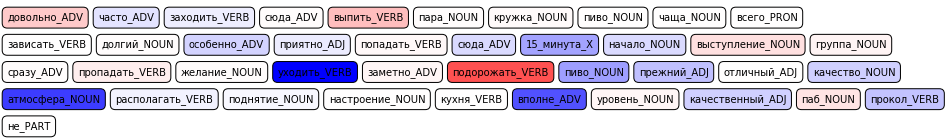

In [0]:
plot_text_heatmap(
    texts_train[0],
    a[0][0]
)

Функция, возвращающая positive_sequences, positive_indices, negative_sequences, negative_indices в данном тексте. В каждом предложении поиск тональных слов происходит отдельно.

In [0]:
def preprocess(input_sents):
    indices = []
    normalized_texts = []
    texts = []
    for input_sent in input_sents:
        normalized_text, pos = normalize(input_sent)
        normalized_texts.append(normalized_text)
        words_with_indices = [(i, pair[0], pair[1]) for i, pair in enumerate(zip(normalized_text, pos)) if pair[0] not in russian_stopwords]
        indices.append([str(elem[0]) for elem in words_with_indices])
        # text_without_stopword = ' '.join([elem[1] for elem in words_with_indices])
        # texts.append([elem[1] for elem in words_with_indices])
        texts.append([f'{elem[1]}_{elem[2]}' for elem in words_with_indices])
        # for gram in grams_to_be_replaced:
        #     text = text_without_stopword.replace(gram, gram.replace(' ', '_'))
        #     for start in [m.start() for m in re.finditer(gram, text_without_stopword)]:
        #         indices[-1][start] = '_'.join([elem for elem in indices[-1][start:start + len(gram.split())]])
        #         indices[-1][start + 1:start + len(gram.split())] = [None] * (len(gram.split()) - 1)
        #     indices[-1] = [elem for elem in indices[-1] if elem is not None]
        # texts.append(text)
    return texts, indices, normalized_texts

In [0]:
def find_seqs_and_inds(input_text, verbose=False):
    input_sents = nltk.sent_tokenize(input_text)
    texts, indices, texts_with_replacements = preprocess(input_sents)

    input_tensor, inp_vocab = load_dataset(texts, w2v_model.vector_size)

    texts_dct = []
    for i_text, text in enumerate(texts):
        texts_dct.append({})
        cmap = plt.cm.ScalarMappable(cmap=cm.bwr)
        cmap.set_clim(0, 1)

        a, y_pred = analyze_scores(input_tensor, i_text)
        if verbose:
            plot_text_heatmap(
                text,
                a[0][0]
            )

        tokens = text
        token_scores = [0] * len(tokens)
        token_rgb = [[0, 0, 0] for i in range(len(tokens))]
        N = 1  # на 4 показывает себя хуже
        for i_score in range(len(a[:N])):
            scores = a[i_score][0]
            normalized_scores = 0.5 * scores / np.max(np.abs(scores)) + 0.5

            for i_token, token in enumerate(tokens):
                token_scores[i_token] += normalized_scores[i_token]
                *rgb, _ = cmap.to_rgba(normalized_scores[i_token], bytes=True)
                token_rgb[i_token][0] += rgb[0]
                token_rgb[i_token][1] += rgb[1]
                token_rgb[i_token][2] += rgb[2]

        token_scores = np.array(token_scores) / N
        token_rgb = np.array(token_rgb) / N
        for i_rgb, rgb in enumerate(token_rgb):
            if rgb[0] > 200:
                if rgb[0] > rgb[2]:
                    token_scores[i_rgb] = 1
                else:
                    token_scores[i_rgb] = 0
            elif rgb[2] > 200:
                if rgb[2] > rgb[0]:
                    token_scores[i_rgb] = 0
                else:
                    token_scores[i_rgb] = 1
            else:
                token_scores[i_rgb] = 0.5

        negative_sequences = []
        negative_indices = []
        positive_sequences = []
        positive_indices = []
        sequence = []
        indices_ = []

        prev_value = 0.5
        for i_token, token_score in enumerate(token_scores):
            if token_score < 0.25:
                if prev_value >= 0.25:
                    if sequence:
                        negative_sequences.append(sequence)
                        negative_indices.append(indices_)
                        sequence = []
                        indices_ = []
                sequence.append(tokens[i_token])
                indices_.append(int(indices[i_text][i_token]))
            elif token_score > 0.75:
                if prev_value <= 0.75:
                    if sequence:
                        positive_sequences.append(sequence)
                        positive_indices.append(indices_)
                        sequence = []
                        indices_ = []
                sequence.append(tokens[i_token])
                indices_.append(int(indices[i_text][i_token]))
            else:
                sequence = []
                indices_ = []
            prev_value = token_score
        if sequence:
            if prev_value > 0.25:
                negative_sequences.append(sequence)
                negative_indices.append(indices_)
            else:
                positive_sequences.append(sequence)
                positive_indices.append(indices_)
        texts_dct[-1]['positive_sequences'] = positive_sequences
        positive_lemmas = [[elem.rsplit('_', 1)[0] for elem in lst] for lst in positive_sequences]
        texts_dct[-1]['positive_lemmas'] = positive_lemmas
        texts_dct[-1]['positive_indices'] = positive_indices
        texts_dct[-1]['negative_sequences'] = negative_sequences
        negative_lemmas = [[elem.rsplit('_', 1)[0] for elem in lst] for lst in negative_sequences]
        texts_dct[-1]['negative_lemmas'] = negative_lemmas
        texts_dct[-1]['negative_indices'] = negative_indices
        if verbose:
            print(f'{i_text}-е предложение: {input_sents[i_text]}')
            print('positive_sequences', positive_sequences)
            print('positive_lemmas', positive_lemmas)
            print('positive_indices', positive_indices)
            print('negative_sequences', negative_sequences)
            print('negative_lemmas', negative_lemmas)
            print('negative_indices', negative_indices)
            print()
    return texts, texts_dct, texts_with_replacements

In [306]:
sents, texts_dct, input_sents = find_seqs_and_inds(
    'Я тут был. Здесь очень хорошо, просто прекрасно! А там было просто отвратительно, ужас!',
    verbose=True
)

0-е предложение: Я тут был.
positive_sequences []
positive_lemmas []
positive_indices []
negative_sequences []
negative_lemmas []
negative_indices []

1-е предложение: Здесь очень хорошо, просто прекрасно!
positive_sequences [['очень_ADV', 'просто_PART', 'прекрасно_ADV']]
positive_lemmas [['очень', 'просто', 'прекрасно']]
positive_indices [[1, 3, 4]]
negative_sequences []
negative_lemmas []
negative_indices []

2-е предложение: А там было просто отвратительно, ужас!
positive_sequences [['ужас_NOUN']]
positive_lemmas [['ужас']]
positive_indices [[5]]
negative_sequences [['просто_PART', 'отвратительный_ADJ']]
negative_lemmas [['просто', 'отвратительный']]
negative_indices [[3, 4]]



# https://github.com/madrugado/Attention-Based-Aspect-Extraction

In [0]:
!git clone https://github.com/madrugado/Attention-Based-Aspect-Extraction.git attention

Cloning into 'attention'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 276 (delta 0), reused 0 (delta 0), pack-reused 272
Receiving objects: 100% (276/276), 129.42 MiB | 33.86 MiB/s, done.
Resolving deltas: 100% (156/156), done.


In [0]:
%cd /content/attention/code/

/content/attention/code


In [0]:
train_set = texts_with_replacements[:19030]
test_set = texts_with_replacements[19030:]

In [0]:
texts_with_replacements[19030:]

['обнаружить салат таракан очень поразить заказать салат ростковый маша будт осторожный',
 'забавный заведение симпатичный светлый интерьер особый интересный акцент исключение очень красивый стена натуральный камень бар мера неудобный диван мера неприветливый персонал отдельный внимание заслуживать меню вид огромный талмуд плотный красивый страница разделить середина закладка гордо обещать гастрономический кухня начать неплохой завтрак который можно употребить любой время сутки но содержание особый изыск не поражать омлетик запеканка далёкий идти салат_цезарь апельсиновый заправка мирно соседствовать оливья закуска гастрономичный селёдочка водочка уживаться фуа гра гранд шавермыть сожаление весь шедевр запомнить не удаться великое множество но общий_впечатление сложиться мир нитка голый мерседес решить повар судить весь_наш соотечественник поэтому пройтись блюдо который русский человек сложно испортить взять рассольник почка оливья раковый шейк запеканка десерт рассольник порадовать ну

In [0]:
directory = '/content/attention/preprocessed_data/restaurant/'
if not os.path.exists(directory):
    os.makedirs(directory)

In [0]:
with open(os.path.join('/content', 'attention', 'preprocessed_data', 'restaurant', 'train.txt'), 'w', encoding='utf-8') as f:
    f.write('\n'.join(train_set))
with open(os.path.join('/content', 'attention', 'preprocessed_data', 'restaurant', 'test.txt'), 'w', encoding='utf-8') as f:
    f.write('\n'.join(test_set))
with open(os.path.join('/content', 'attention', 'preprocessed_data', 'restaurant', 'test_label.txt'), 'w', encoding='utf-8') as f:
    f.write('еда\nинтерьер\nобщее\nинтерьер')

In [0]:
# NB: раскомментить первую строчку # main('restaurant')
!python word2vec.py

Pre-training word embeddings ...
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
directory = '/content/attention/datasets/restaurant/'
if not os.path.exists(directory):
    os.makedirs(directory)

In [0]:
with open(os.path.join('/content', 'attention', 'datasets', 'restaurant', 'train.txt'), 'w', encoding='utf-8') as f:
    f.write('\n'.join(train_set))
with open(os.path.join('/content', 'attention', 'datasets', 'restaurant', 'test.txt'), 'w', encoding='utf-8') as f:
    f.write('\n'.join(test_set))
with open(os.path.join('/content', 'attention', 'datasets', 'restaurant', 'test_label.txt'), 'w', encoding='utf-8') as f:
    f.write('еда\nинтерьер\nобщее\nинтерьер')

In [0]:
# NB: поменять english на russian
!python preprocess.py

	restaurant train set ...
	restaurant test set ...


In [0]:
with open(os.path.join('/content', 'attention', 'preprocessed_data', 'restaurant', 'test.txt'), 'w', encoding='utf-8') as f:
    f.write('\n'.join(test_set))
with open(os.path.join('/content', 'attention', 'preprocessed_data', 'restaurant', 'test_label.txt'), 'w', encoding='utf-8') as f:
    f.write('еда\nинтерьер\nобщее\nинтерьер')

In [0]:
!python train.py --emb-name w2v_embedding --domain restaurant -o output_dir

Using TensorFlow backend.
2019-12-24 21:09:09,547 INFO Arguments:
2019-12-24 21:09:09,547 INFO   algorithm: adam
2019-12-24 21:09:09,547 INFO   aspect_size: 14
2019-12-24 21:09:09,547 INFO   batch_size: 32
2019-12-24 21:09:09,547 INFO   command: train.py --emb-name w2v_embedding --domain restaurant -o output_dir
2019-12-24 21:09:09,547 INFO   domain: restaurant
2019-12-24 21:09:09,547 INFO   emb_dim: 100
2019-12-24 21:09:09,547 INFO   emb_name: w2v_embedding
2019-12-24 21:09:09,548 INFO   epochs: 15
2019-12-24 21:09:09,548 INFO   maxlen: 256
2019-12-24 21:09:09,548 INFO   neg_size: 20
2019-12-24 21:09:09,548 INFO   ortho_reg: 0.1
2019-12-24 21:09:09,548 INFO   out_dir_path: output_dir
2019-12-24 21:09:09,548 INFO   seed: 1234
2019-12-24 21:09:09,548 INFO   vocab_size: 9000
Reading data from restaurant
 Creating vocab ...
   1291051 total words, 49774 unique words
  keep the top 9000 words
 Reading dataset ...
  train set
   <num> hit rate: 1.33%, <unk> hit rate: 7.90%
  test set
   <nu

In [0]:
with open(os.path.join('output_dir', 'restaurant', 'aspect.log'), 'rb') as f:
    aspects = f.readlines()

In [0]:
aspects = [line.decode('utf-8') for line in aspects[1::3]]

In [0]:
aspects

['попёс|0.6352998 ливерпуль|0.61129445 ых|0.6093304 прибавить|0.605039 немолодой|0.58019257 градус|0.56674707 food|0.5652636 good|0.5648364 of|0.5647703 хх|0.56218565 ого|0.5567466 restaurant|0.55609477 service|0.5550951 best|0.5518943 ка|0.55111843 were|0.5503586 ти|0.550017 прайс|0.5485428 wa|0.5483969 in|0.54838413 доллар|0.5479593 процент|0.547202 бальный|0.5443928 it|0.54213744 блюз|0.5420893 полуночь|0.54098743 no|0.539497 студентка|0.5390347 very|0.537882 my|0.5366709 выключать|0.53531885 and|0.5341884 па|0.5334455 девять|0.5321678 космический|0.53191686 тридцать|0.53085804 копейка|0.5307034 двенадцать|0.5301528 заполняемость|0.52955925 this|0.52950567 we|0.5285265 рок|0.5256958 ролик|0.5249218 приблизительно|0.5246199 the|0.52453905 пятьдесят|0.5220612 бурный|0.52141726 этак|0.5207213 you|0.51983607 that|0.5188121 удар|0.5186753 потянуть|0.5163945 отстой|0.5158046 справедливо|0.5147265 парный|0.5146583 negativa|0.51417553 шансон|0.51405585 мировой|0.5140168 пт|0.51334643 all|0.

In [0]:
# раскомментировать в evaluation.py >= 146 строчки
# и на 61 строчке поменять топики
# добавить на 59 строчку следующее: true_label = ['Food'] * len(predict_label)
cluster_map = {
    0: 'Other',
    1: 'Food',
    2: 'Food',
    3: 'Other',
    4: 'Service',
    5: 'Other',
    6: 'Other',
    7: 'Food',
    8: 'Other',
    9: 'Other',
    10: 'Other',
    11: 'Other',
    12: 'Other',
    13: 'Food'
}

In [0]:
!python evaluation.py --domain restaurant -o output_dir

Using TensorFlow backend.
Reading data from restaurant
 Creating vocab ...
   1291051 total words, 49774 unique words
  keep the top 9000 words
 Reading dataset ...
  train set
   <num> hit rate: 1.33%, <unk> hit rate: 7.90%
  test set
   <num> hit rate: 2.74%, <unk> hit rate: 11.59%





2019-12-24 21:17:51.791634: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2300000000 Hz
2019-12-24 21:17:51.791976: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x8934680 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2019-12-24 21:17:51.792046: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2019-12-24 21:17:51.794290: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2019-12-24 21:17:51.892026: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative

Дистрибутивная семантика

In [0]:
food_v = (w2v_model.wv['еда_NOUN'] + w2v_model.wv['напиток_NOUN']) / 2
service_v = (w2v_model.wv['обслуживание_NOUN'] + w2v_model.wv['официант_NOUN'] + w2v_model.wv['услуга_NOUN'] + w2v_model.wv['время_NOUN'] + w2v_model.wv['комфорт_NOUN']) / 5

In [0]:
from scipy import spatial

def asp(sent, ind, food_v, service_v):

    lenghth = 0
    res = np.zeros((w2v_model.vector_size,), dtype = 'float32')
    tokens = sent.split()
    for word in tokens[max(0, ind[0]-3):min(len(tokens), ind[-1]+1)]:
        if word in w2v_model.wv.vocab:
                lenghth += 1
                res += w2v_model.wv[word]
    for word in tokens[max(0, ind[-1]+1):min(len(tokens), ind[-1]+4)]:
        if word in w2v_model.wv.vocab:
                lenghth += 1
                res += w2v_model.wv[word]
    res = res/lenghth
    score_food = 1 - spatial.distance.cosine(res, food_v)
    score_service = 1 - spatial.distance.cosine(res, service_v)
    if score_service < 0.22 and score_food < 0.22:
        return 'Other'
    elif score_service > score_food:
        return 'Service'
    else:
        return 'Food'

In [0]:
asp('очень понравиться карбанара', [2], food_v, service_v)

'Food'

Предсказания

In [0]:
negative_asp = []
negative_sents = []
positive_asp = []
positive_sents = []
for i in range(len(sents)):
    for negative_index in texts_dct[i]['negative_indices']:
        negative_asp.append(asp(' '.join(sents[i]), negative_index, food_v, service_v))
        tokens = sents_with_replacements[i].split()
        negative_sents.append(' '.join(tokens[max(0, negative_index[0]-3):min(len(tokens), negative_index[-1]+4)]))

    for positive_index in texts_dct[i]['positive_indices']:
        positive_asp.append(asp(' '.join(sents[i]), positive_index, food_v, service_v))
        tokens = sents_with_replacements[i].split()
        positive_sents.append(' '.join(tokens[max(0, positive_index[0]-3):min(len(tokens), positive_index[-1]+4)]))

In [0]:
negative_asp

['Other', 'Other', 'Other']

In [0]:
negative_sents

['здравствовать виа далее арженто добрый',
 'здравствовать виа далее арженто добрый вечер хотеть заказать',
 'ваш метродотеля елена девушка вообще не уметь']

In [0]:
with open(os.path.join('/content', 'attention', 'preprocessed_data', 'restaurant', 'test.txt'), 'w', encoding='utf-8') as f:
    f.write('\n'.join(negative_sents))

In [0]:
# на 25-26 строках заменить на следующее:
# vocab, train_x, test_x, overall_maxlen = dataset.get_data(args.domain, vocab_size=args.vocab_size, maxlen=args.maxlen)
# # test_x = train_x  # <-- здесь коммент

# Также нужно добавить запись в файл после 60-й строчки:
# with open('output_dir/restaurant/labels.txt', 'w', encoding='utf-8') as f:
#     f.write('\n'.join(predict_label))

!python evaluation.py --domain restaurant -o output_dir

Using TensorFlow backend.
Reading data from restaurant
 Creating vocab ...
   1291051 total words, 49774 unique words
  keep the top 9000 words
 Reading dataset ...
  train set
   <num> hit rate: 1.33%, <unk> hit rate: 7.90%
  test set
   <num> hit rate: 0.00%, <unk> hit rate: 30.00%





2019-12-24 21:38:12.491044: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2300000000 Hz
2019-12-24 21:38:12.491431: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x73b1880 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2019-12-24 21:38:12.491485: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2019-12-24 21:38:12.493737: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2019-12-24 21:38:12.589538: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative

In [0]:
with open('output_dir/restaurant/labels.txt', 'r', encoding='utf-8') as f:
    negative_aspect = f.read().split('\n')

In [0]:
negative_aspect

['Other', 'Other', 'Other']

In [0]:
with open(os.path.join('/content', 'attention', 'preprocessed_data', 'restaurant', 'test.txt'), 'w', encoding='utf-8') as f:
    f.write('\n'.join(positive_sents))

In [0]:
!python evaluation.py --domain restaurant -o output_dir

Using TensorFlow backend.
Reading data from restaurant
 Creating vocab ...
   1291051 total words, 49774 unique words
  keep the top 9000 words
 Reading dataset ...
  train set
   <num> hit rate: 1.33%, <unk> hit rate: 7.90%
  test set
   <num> hit rate: 0.00%, <unk> hit rate: 28.57%





2019-12-24 21:38:33.081626: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2300000000 Hz
2019-12-24 21:38:33.082114: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x75d9880 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2019-12-24 21:38:33.082170: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2019-12-24 21:38:33.084115: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2019-12-24 21:38:33.174560: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative

In [0]:
with open('output_dir/restaurant/labels.txt', 'r', encoding='utf-8') as f:
    positive_aspect = f.read().split('\n')

In [0]:
positive_aspect

['Other', 'Other']

В цикле

In [0]:
with open(os.path.join(drive_prefix, 'parsed_texts.json'), 'r', encoding='utf-8') as f:
    dct = json.load(f)
    texts = dct['source_texts']

In [325]:
# negative_asp = []
# negative_lemmas = []
# negative_sents = []

# positive_asp = []
# positive_lemmas = []
# positive_sents = []

# for text in tqdm(texts, total=len(texts)):
#     sents, texts_dct, input_sents = find_seqs_and_inds(text)
#     for i in range(len(sents)):
#         tokens = input_sents[i]

#         for negative_index in texts_dct[i]['negative_indices']:
#             negative_asp.append(asp(' '.join(sents[i]), negative_index, food_v, service_v))
#             negative_sents.append(' '.join(tokens[:min(len(tokens), negative_index[-1]+4)]))
#             negative_lemmas.append(' '.join(tokens[index] for index in negative_index))

#         for positive_index in texts_dct[i]['positive_indices']:
#             positive_asp.append(asp(' '.join(sents[i]), positive_index, food_v, service_v))
#             positive_sents.append(' '.join(tokens[max(0, positive_index[0]-3):min(len(tokens), positive_index[-1]+4)]))
#             positive_lemmas.append(' '.join(tokens[index] for index in positive_index))

100%|██████████| 19034/19034 [2:02:28<00:00,  2.71it/s]


In [0]:
# with open(os.path.join(drive_prefix, 'saved_tonal_expressions.json'), 'w', encoding='utf-8') as f:
#     json.dump({
#         'negative_asp': negative_asp,
#         'negative_lemmas': negative_lemmas,
#         'negative_sents': negative_sents,
#         'positive_asp': positive_asp,
#         'positive_lemmas': positive_lemmas,
#         'positive_sents': positive_sents
#     }, f)

In [0]:
with open(os.path.join(drive_prefix, 'saved_tonal_expressions.json'), 'r', encoding='utf-8') as f:
    dct = json.load(f)
    negative_asp = dct['negative_asp']
    negative_lemmas = dct['negative_lemmas']
    negative_sents = dct['negative_sents']
    positive_asp = dct['positive_asp']
    positive_lemmas = dct['positive_lemmas']
    positive_sents = dct['positive_sents']

In [0]:
# Чтобы в colab-е tqdm хорошо работала
for instance in list(tqdm._instances):
    tqdm._decr_instances(instance)

In [335]:
# with open(os.path.join('/content', 'attention', 'preprocessed_data', 'restaurant', 'test.txt'), 'w', encoding='utf-8') as f:
#     f.write('\n'.join(negative_sents))
# !python evaluation.py --domain restaurant -o output_dir
# with open('output_dir/restaurant/labels.txt', 'r', encoding='utf-8') as f:
#     negative_aspect = f.read().split('\n')

Using TensorFlow backend.
Reading data from restaurant
 Creating vocab ...
   1291051 total words, 49774 unique words
  keep the top 9000 words
 Reading dataset ...
  train set
   <num> hit rate: 1.33%, <unk> hit rate: 7.90%
  test set
   <num> hit rate: 1.48%, <unk> hit rate: 39.91%





2019-12-25 01:37:59.839967: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2300000000 Hz
2019-12-25 01:37:59.840353: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x46e8680 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2019-12-25 01:37:59.840401: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2019-12-25 01:37:59.842404: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2019-12-25 01:37:59.937486: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative

In [341]:
# with open(os.path.join('/content', 'attention', 'preprocessed_data', 'restaurant', 'test.txt'), 'w', encoding='utf-8') as f:
#     f.write('\n'.join(positive_sents))
# !python evaluation.py --domain restaurant -o output_dir
# with open('output_dir/restaurant/labels.txt', 'r', encoding='utf-8') as f:
#     positive_aspect = f.read().split('\n')

Using TensorFlow backend.
Reading data from restaurant
 Creating vocab ...
   1291051 total words, 49774 unique words
  keep the top 9000 words
 Reading dataset ...
  train set
   <num> hit rate: 1.33%, <unk> hit rate: 7.90%
  test set
   <num> hit rate: 1.46%, <unk> hit rate: 37.41%





2019-12-25 01:44:17.804423: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2300000000 Hz
2019-12-25 01:44:17.804745: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x2561b880 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2019-12-25 01:44:17.804778: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2019-12-25 01:44:17.806874: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2019-12-25 01:44:17.902765: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negativ

In [0]:
# with open(os.path.join(drive_prefix, 'saved_tonal_expressions_2.json'), 'w', encoding='utf-8') as f:
#     json.dump({
#         'negative_aspect': negative_aspect,
#         'positive_aspect': positive_aspect
#     }, f)

In [0]:
with open(os.path.join(drive_prefix, 'saved_tonal_expressions_2.json'), 'r', encoding='utf-8') as f:
    dct = json.load(f)
    negative_aspect = dct['negative_aspect']
    positive_aspect = dct['positive_aspect']

In [0]:
num_food_2 = 0
num_food_1 = 0
positive_food = []
negative_food = []
positive_service = []
negative_service = []
for i, (asp, aspect) in enumerate(zip(positive_asp, positive_aspect)):
    if asp == 'Food' and aspect == 'Food':
        positive_food.append(positive_lemmas[i])
    elif asp == 'Service' and aspect == 'Service':
        positive_service.append(positive_lemmas[i])
for i, (asp, aspect) in enumerate(zip(negative_asp, negative_aspect)):
    if asp == 'Food' and aspect == 'Food':
        negative_food.append(negative_lemmas[i])
    elif asp == 'Service' and aspect == 'Service':
        negative_service.append(negative_lemmas[i])

In [367]:
print('food:', len(positive_food), len(negative_food))
print('service:', len(positive_service), len(negative_service))

food: 86906 74590
service: 12145 9422


In [0]:
N = 3
positive_food = [elem for elem in positive_food if len(elem.split()) > N]
negative_food = [elem for elem in negative_food if len(elem.split()) > N]
positive_service = [elem for elem in positive_service if len(elem.split()) > N]
negative_service = [elem for elem in negative_service if len(elem.split()) > N]

In [382]:
print('food:', len(positive_food), len(negative_food))
print('service:', len(positive_service), len(negative_service))

food: 23238 8721
service: 3445 1241


In [0]:
with open(os.path.join(drive_prefix, 'results.csv'), 'w', newline='') as f:
    for food in positive_food:
        f.write('\t'.join(['Food', food, '1']) + '\n')
    for food in negative_food:
        f.write('\t'.join(['Food', food, '0']) + '\n')
    for service in positive_service:
        f.write('\t'.join(['Service', service, '1']) + '\n')
    for service in negative_service:
        f.write('\t'.join(['Service', service, '0']) + '\n')

In [386]:
import random
random.sample(positive_food, 10)

['тыква соус белых грибов пальчик облизать',
 'горький шоколад каштан целиком',
 'еда качественный домашний слово объедение',
 'идти сливовый столовый 3 литр',
 'мясо очень вкусный мягкий',
 'основный меню понравиться рыба',
 'эногастрономический бутик хороший выбор стартер',
 'красивый судить скорость уничтожение',
 'профитролина внутри мороженое полить горячее шоколад',
 'паста трюфельный соус очень вкусно десерт']

In [387]:
random.sample(negative_food, 10)

['филе цыплёнок тайский маринад зелёный фасоль',
 'это бармен найти печальный опыт',
 'москва бездарный кухня мочь',
 'оля хамон свиной полоска',
 'приносить вино бокал брачок',
 'лимонный действительно очень кислый тирамис',
 'вкус средний творожный запеканка морковный',
 'фрукт икра весь алкоголь весь алкогольный напиток',
 'бутылка выпить вдвоём физически',
 'ребёнок уронить бокал морс мама']

In [388]:
random.sample(positive_service, 10)

['персонал приветливый ряд готовый выполнить',
 'опасность самый дальний зал',
 'официант практически незаметный оказываться',
 'персонал исключение официантка остальной настолько',
 'администратор извиниться далёкий весь достаточно оперативно',
 'особенно порадовать девушка вход',
 'официант весь растащить особо никуда',
 'встречать вход проводить стол',
 'обслужить достаточно быстро официантка особо',
 'сотрудник очень вежливый милый']

In [389]:
random.sample(negative_service, 10)

['обслуживание хы хы хы бармен',
 'увернуться бокал официантка поведать ситуация происходить',
 'обслуживание нормальный поменяться мелочь частота смена пепельница',
 'официантка нормальный бармен коля сережа',
 'крайне неприятный впечатление персонал',
 'сервис работать кухня подтянуть',
 'попить кофе свободный место промежуточный счёт это',
 'молодая человек сожаление имя узнать',
 'вежливый сказать 15 минута',
 'запах предложить пересесть комфортный']